In [1]:
import pandas as pd
from pathlib import Path
import sys
import os
import numpy as np
import re
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

sys.path.append(os.path.abspath('../src'))
project_dir = project_dir = Path.cwd().parent

# Set max delay (period is months)
D_serotype = 36 # 3 years

# GISAID settings:
# Location: South America, Brazil
# Collection: 2002-12-31 -> 2012-12-31 + 2012-12-31 -> 2020-12-31

def extract_Typetype(s):
    match = re.search(r'DenV(\d)', s, re.IGNORECASE)
    if match:
        return f"DENV-{match.group(1)}"
    else:
        return None  # or some default# Total as off 23/07/25 is 2525

In [2]:
split_type = "sero"

# Combine all excel files into one df
base_folder_path = project_dir / "data" / "raw" / "DENV"
files = [f for f in os.listdir(base_folder_path) if f.endswith('.xlsx')]
dfs = []

for file in files:

    file_path = os.path.join(base_folder_path, file)
    all_sheets = pd.read_excel(file_path, sheet_name=None)
    for sheet_name, df_folder in all_sheets.items():
        df_folder = df_folder.assign(source_file=file, sheet_name=sheet_name)
        EPI = df_folder['seqName'].str.split('|', expand=True) [1]
        if 'EPI_ISL_19890341' in EPI:
            print(df_folder)
        try:
            if split_type == "geno":
                type_name = df_folder['clade'].str.split('_', expand=True)[0]
            elif split_type == "sero":
                type_name = df_folder['clade'].str.split('_', expand=True)[0]
                type_name = type_name.str[0]


        # except:
        #     seq = df_folder['seqName'].str.split('|', expand=True)[0]
        #     seq = seq.str.split('/', expand=True)[0]
        #     geno = np.array([extract_typetype(x) for x in seq])
        except:
            type_name = "unassigned"
            

        df = pd.DataFrame({
            "EPI": EPI,
            "Type": type_name
        })
        df = df[df['Type'] != 'unassigned']
        df = df[df['Type'] != 'u']
        dfs.append(df)

denv_df = pd.concat(dfs, ignore_index=True)
denv_df = denv_df.drop_duplicates(subset='EPI')

denv_dates = pd.read_csv(os.path.join(base_folder_path, "DENV dates.tsv"), sep='\t')
denv_df = denv_df.merge(denv_dates, left_on='EPI', right_on='Accession ID', how='left')
denv_df = denv_df.drop(columns='Accession ID')
denv_df



,EPI,Type,Collection date,Submission date,Location
0,EPI_ISL_17439271,1,2013,2017-03-24,South America / Brazil
1,EPI_ISL_17439274,1,2013,2017-03-24,South America / Brazil
2,EPI_ISL_17439278,1,2013,2017-03-24,South America / Brazil
3,EPI_ISL_17439280,1,2013,2017-03-24,South America / Brazil
4,EPI_ISL_17439282,1,2013,2017-03-24,South America / Brazil
...,...,...,...,...,...
7007,EPI_ISL_939757,2,2019-05-02,2021-02-05,South America / Brazil
7008,EPI_ISL_939758,2,2019-04-28,2021-02-05,South America / Brazil
7009,EPI_ISL_939759,2,2019-04-26,2021-02-05,South America / Brazil
7010,EPI_ISL_939770,2,2019-02-22,2021-02-05,South America / Brazil


In [3]:
print(denv_df['Type'].nunique())

4


In [4]:
# Note some dates just contain years
def fix_date(val):
    if isinstance(val, str):
        val = val.strip()

        # Year only: "2018"
        if re.fullmatch(r"\d{4}", val):
            return f"{val}-01-01"
        
        # Year-Month: "2018-07" or "2018/07"
        if re.fullmatch(r"\d{4}[-/]\d{1,2}", val):
            parts = re.split("[-/]", val)
            year, month = parts
            return f"{year}-{int(month):02d}-01"
        
        # Month-Year: "07/2018" or "07-2018"
        if re.fullmatch(r"\d{1,2}[-/]\d{4}", val):
            parts = re.split("[-/]", val)
            month, year = parts
            return f"{year}-{int(month):02d}-01"
        
    return val  # Leave as-is if not matched



denv_df['Collection date'] = denv_df['Collection date'].apply(fix_date)
denv_df['Submission date'] = denv_df['Submission date'].apply(fix_date)

denv_df['Collection date'] = pd.to_datetime(denv_df['Collection date']).dt.to_period('M')
denv_df['Submission date'] = pd.to_datetime(denv_df['Submission date']).dt.to_period('M')

denv_df['Type'].nunique()




4

In [5]:

# Create Delay
denv_df['Delay'] = np.array((denv_df['Submission date'] - denv_df['Collection date']).apply(lambda x: x.n))

# Filter by max delay
print(f"Max delay was {denv_df['Delay'].max()}, dropping {len(denv_df[denv_df['Delay']>=D_serotype])} samples")
denv_df = denv_df[denv_df['Delay']<D_serotype]

denv_df = denv_df.sort_values(by='Collection date')
denv_df
denv_df['Type'].nunique()

Max delay was 283, dropping 1467 samples


4

In [6]:
start_month = denv_df['Collection date'].min()
end_month = denv_df['Collection date'].max()
all_months = pd.period_range(start=start_month, end=end_month, freq='M')
all_types = denv_df['Type'].unique()



# Create full grid of Month × Type combinations
all_combinations = pd.MultiIndex.from_product(
    [all_months, all_types], names=['Collection date', 'Type']
).to_frame(index=False)




In [7]:
counts = denv_df.groupby(['Collection date', 'Type']).size().reset_index(name='Count')
counts
full_counts = pd.merge(all_combinations, counts, on=['Collection date', 'Type'], how='left')
full_counts['Count'] = full_counts['Count'].fillna(0).astype(int)
full_counts['Proportion'] = full_counts['Count'] / full_counts.groupby('Collection date')['Count'].transform('sum')
full_counts = full_counts.sort_values(['Type', 'Collection date']).reset_index(drop=True)

unobserved_months = full_counts[full_counts['Proportion'].isna()]['Collection date'].unique()
print(unobserved_months)

for month in unobserved_months:
    for i in range(1, 12):
        prev_vals = full_counts[full_counts['Collection date'] == (month - i)]['Proportion']
        if sum(prev_vals.isna()) == 0:
            break
        print("First months do not have sufficient data collect more!!!!")
    full_counts.loc[full_counts['Collection date'] == month, 'Proportion'] = prev_vals.values

full_counts['Proportion'] = pd.to_numeric(full_counts['Proportion'], errors='coerce').astype(np.float32)
full_counts['Collection date'] = full_counts['Collection date'].dt.to_timestamp()

type_props = full_counts.pivot(index='Collection date', columns='Type', values='Proportion').sort_index()

<PeriodArray>
['2001-02', '2001-03', '2001-04', '2001-05', '2001-06', '2001-07', '2001-08',
 '2001-09', '2001-10', '2001-11',
 ...
 '2019-11', '2019-12', '2020-05', '2020-06', '2020-07', '2020-08', '2020-09',
 '2020-10', '2020-11', '2020-12']
Length: 154, dtype: period[M]


In [8]:
type_props = type_props[type_props.index >= pd.to_datetime("2013-01-01")]

In [9]:
type_props

Type,1,2,3,4
Collection date,,,,
2013-01-01,0.387097,0.172043,0.010753,0.430108
2013-02-01,0.096774,0.096774,0.000000,0.806452
2013-03-01,0.000000,0.000000,0.000000,1.000000
2013-04-01,0.000000,0.000000,0.000000,1.000000
2013-05-01,0.054545,0.072727,0.200000,0.672727
...,...,...,...,...
2023-08-01,0.894737,0.105263,0.000000,0.000000
2023-09-01,0.777778,0.222222,0.000000,0.000000
2023-10-01,0.866667,0.100000,0.033333,0.000000


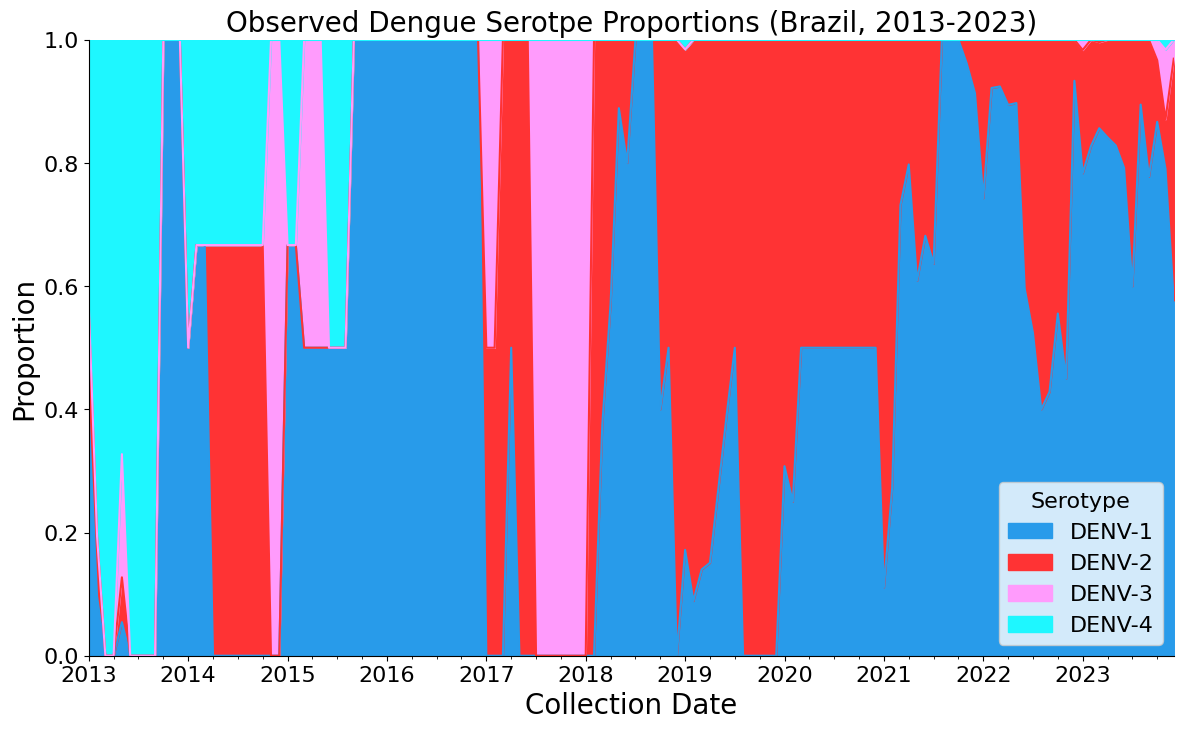

In [19]:
type_props.columns = ["DENV-1", "DENV-2", "DENV-3", "DENV-4"]


# Function to adjust brightness
def adjust_color_brightness(color_hex, factor=1.2):
    """
    Adjust brightness of a hex color.
    factor > 1: lighter, factor < 1: darker
    """
    rgb = mcolors.to_rgb(color_hex)
    adjusted = tuple(min(1, c * factor) for c in rgb)
    return mcolors.to_hex(adjusted)

# Default matplotlib line colors (first four)
base_colors = ['#1f77b4', '#d62728', '#e377c2', '#17becf']


colors = [adjust_color_brightness(c, factor=1.3) for c in base_colors]

fig, ax = plt.subplots(figsize=(14, 8))
ax.set_ylim(0, 1)

type_props.plot.area(ax=ax, alpha=1, color=colors)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.title('Observed Dengue Serotpe Proportions (Brazil, 2013-2023)', fontsize=20)
plt.xlabel('Collection Date', fontsize=20)
plt.ylabel('Proportion', fontsize=20)
plt.legend(title='Serotype', fontsize=16, title_fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig(project_dir / "src" / "outputs" / "visuals" / "serotype-nowcasts" / "true_proportions", bbox_inches="tight", dpi=300)
plt.show()


In [11]:
denv_df['Type'].nunique()

4

In [12]:
type_props.columns

Index(['1', '2', '3', '4'], dtype='object', name='Type')

In [13]:
type_all = type_props.columns
num_type = len(type_all)


start_date = str(denv_df['Collection date'].min())
end_date = str(denv_df['Collection date'].max() + 1)



all_dates = pd.date_range(start_date,end_date, freq='ME').to_period('M')
all_delays = np.arange(0, D_serotype)

type_tensor = []
for type_name in type_all:
    type_df = denv_df[denv_df['Type'] == type_name]

    full_index = pd.MultiIndex.from_product(
        [all_dates, all_delays],
        names=['Collection date', 'Delay']
    )


    observed_counts = (
        type_df
        .groupby(['Collection date', 'Delay'])
        .size()
        .reindex(full_index, fill_value=0)
        .rename('Count')
    )
    assert observed_counts.sum() == len(denv_df[denv_df['Type'] == type]), f"Wrong number of samples for type {type}"

    # 5. Convert to a 2D pivot table (for easier viewing or modeling)
    pivot_table = (
        observed_counts
        .reset_index()
        .pivot(index='Collection date', columns='Delay', values='Count')
        .fillna(0)
        .astype(int)
    )
    type_tensor.append(pivot_table)

type_tensor = np.array(type_tensor)


AssertionError: Wrong number of samples for type <class 'type'>

In [ ]:
# check pivot tables working as expected
print(type_tensor.shape)

assert type_tensor.sum() == len(denv_df), "Missing samples"


(11, 276, 36)


In [ ]:
np.save(project_dir / "data" / "transformed" / 'type_name_tensor.npy', type_tensor)
denv_df.to_csv(project_dir / "data" / "transformed" / 'denv_df.csv', index=True)
type_props.to_csv(project_dir / "data" / "transformed" / 'type_name_props.csv', index=True)


In [ ]:
denv_df


,EPI,Type,Collection date,Submission date,Location,Delay
5452,EPI_ISL_17451350,1V,2001-01,2002-05,South America / Brazil / Parana,16
6033,EPI_ISL_17434408,3III,2003-01,2005-07,South America / Brazil,30
6036,EPI_ISL_17434436,3III,2003-01,2005-07,South America / Brazil,30
6038,EPI_ISL_17434439,3III,2003-01,2005-07,South America / Brazil,30
6030,EPI_ISL_17434401,3III,2003-01,2005-07,South America / Brazil,30
...,...,...,...,...,...,...
3660,EPI_ISL_19115824,1V,2023-12,2024-05,South America / Brazil / Tocantins / Palmas,5
3659,EPI_ISL_19076615,1V,2023-12,2024-04,South America / Brazil / Minas Gerais,4
3658,EPI_ISL_19076613,1V,2023-12,2024-04,South America / Brazil / Minas Gerais,4
3822,EPI_ISL_19035515,1V,2023-12,2024-04,South America / Brazil / Rio de Janeiro / Macae,4


In [ ]:
print(type_props)

Type             1IV        1V   2I       2II      2III   2V   3I      3III  \
Collection date                                                               
2001-01-01       0.0  1.000000  0.0  0.000000  0.000000  0.0  0.0  0.000000   
2001-02-01       0.0  1.000000  0.0  0.000000  0.000000  0.0  0.0  0.000000   
2001-03-01       0.0  1.000000  0.0  0.000000  0.000000  0.0  0.0  0.000000   
2001-04-01       0.0  1.000000  0.0  0.000000  0.000000  0.0  0.0  0.000000   
2001-05-01       0.0  1.000000  0.0  0.000000  0.000000  0.0  0.0  0.000000   
...              ...       ...  ...       ...       ...  ...  ...       ...   
2023-08-01       0.0  0.894737  0.0  0.052632  0.052632  0.0  0.0  0.000000   
2023-09-01       0.0  0.777778  0.0  0.222222  0.000000  0.0  0.0  0.000000   
2023-10-01       0.0  0.866667  0.0  0.100000  0.000000  0.0  0.0  0.033333   
2023-11-01       0.0  0.790323  0.0  0.080645  0.000000  0.0  0.0  0.112903   
2023-12-01       0.0  0.576923  0.0  0.392308  0.000

In [ ]:
type_all

Index(['1IV', '1V', '2I', '2II', '2III', '2V', '3I', '3III', '3V', '4I',
       '4II'],
      dtype='object', name='Type')